In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

import torch
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data = pd.read_csv('../input/eestech-challenge-4-local-round-xanthi/dataset.csv', header=0)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eestech-challenge-4-local-round-xanthi/model_scripted.pt
/kaggle/input/eestech-challenge-4-local-round-xanthi/query_model.py
/kaggle/input/eestech-challenge-4-local-round-xanthi/dataset.csv


In [2]:
data.head(10)

,poi_0,poi_1,poi_2,poi_3,poi_4,poi_5,poi_6,poi_7,poi_8,poi_9,...,poi_3449,poi_3450,poi_3451,poi_3452,poi_3453,poi_3454,poi_3455,poi_3456,poi_3457,target
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [3]:
print(len(data), sorted(data['target'].value_counts(), reverse=True)[:10])

7767 [3048, 931, 618, 551, 321, 275, 259, 239, 228, 227]


In [4]:
columns = list(data.columns)
columns = columns[:len(columns) - 1]
X = data.loc[:, columns].to_numpy()
y = data.target.to_numpy().ravel()

In [5]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, train_size=5436, test_size=2331,
                                                                                 random_state=0, shuffle=True)

In [6]:
len(indices_train), len(indices_test)

(5436, 2331)

In [7]:
indices_train

array([4923,  849, 6769, ..., 1653, 2607, 2732])

In [8]:
indices_test

array([1726, 1085, 2404, ..., 3517,  923, 7433])

In [9]:
membership = dict()
for idx in indices_train:
    membership[idx] = 1
for idx in indices_test:
    membership[idx] = 0

In [10]:
num_classes = len(np.unique(y_train))
counts_train = np.bincount(y_train)
counts_test = np.bincount(y_test)

print(f"Found {num_classes} classes")
print("Number of samples per class (train)", {i: counts_train[i] for i in range(len(counts_train))})
print("Number of samples per class (test)", {i: counts_test[i] for i in range(len(counts_test))})

Found 18 classes
Number of samples per class (train) {0: 183, 1: 141, 2: 228, 3: 2135, 4: 172, 5: 129, 6: 192, 7: 383, 8: 55, 9: 47, 10: 648, 11: 147, 12: 157, 13: 96, 14: 69, 15: 444, 16: 145, 17: 65}
Number of samples per class (test) {0: 56, 1: 56, 2: 93, 3: 913, 4: 87, 5: 71, 6: 83, 7: 168, 8: 26, 9: 16, 10: 283, 11: 59, 12: 70, 13: 42, 14: 31, 15: 174, 16: 83, 17: 20}


In [11]:
class ClassifierDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)
    
def generate_dataset(train_x, train_y, batch_size, shuffle=True):
    dataset = ClassifierDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).long())
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

In [12]:
train_loader = generate_dataset(X_train, y_train, batch_size=1024, shuffle=True)
test_loader = generate_dataset(X_test, y_test, batch_size=1024, shuffle=True)

In [13]:
print(f"Training set size: ({X_train.shape},{y_train.shape}), Testing set size: ({X_test.shape},{y_test.shape})")

Training set size: ((5436, 3458),(5436,)), Testing set size: ((2331, 3458),(2331,))


In [14]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 128)
        self.out = torch.nn.Linear(128, num_classes)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [15]:
def test(model, data, criterion, prob=False):
    model.eval()
    loss, correct = 0., 0
    probabilities, labels = [], []
    if prob:
        softmax = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        for x, y in data:
            out = model(x)
            if prob:
                probability = softmax(out)
                probabilities.append(probability.flatten().tolist())
            loss += criterion(out, y).item()
            pred = out.argmax(dim=1)

            correct += int((pred == y).sum().item())
            labels.extend(y.tolist())
    loss = loss / len(data)
    accuracy = correct / len(data.dataset)

    if prob:
        return probabilities, loss, accuracy, np.array(labels)

    return loss, accuracy

def train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=1, plot=True):
    train_loss_history, train_acc_history = [], []  # track loss, accuracy
    test_loss_history, test_acc_history = [], []
    for epoch in range(1, epochs + 1):
        model.train()  # training mode
        for data, target in train_loader:
            optimizer.zero_grad()  # zero out gradients
            y_pred = model(data)  # forward propagation
            loss = criterion(y_pred, target)  # calculate loss
            loss.backward()  # backward pass, compute grads wrt to model parameters
            optimizer.step()  # update weights

        train_loss, train_acc = test(model, train_loader, criterion)  # test the model
        test_loss, test_acc = test(model, test_loader, criterion)

        train_acc_history.append(train_acc)  # keep metric history
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % log_interval == 0:  # log
            print(f"Epoch: [{epoch}/{epochs}]: Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
            print(f"\tEval Accuracy: {test_acc}, Loss: {test_loss:.4f}")

    if plot:  # plot history
        plt.plot(train_acc_history, label="Train Acc")
        plt.plot(test_acc_history, label="Test Acc")
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(train_loss_history, label="Train Loss")
        plt.plot(test_loss_history, label="Test Loss")
        plt.legend()
        plt.show()
        plt.close()

    return model

In [16]:
model = MLP(X_train.shape[1], num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
epochs = 150

Epoch: [20/150]: Accuracy: 0.9369, Loss: 0.3422
	Eval Accuracy: 0.7876447876447876, Loss: 0.7002
Epoch: [40/150]: Accuracy: 0.9866, Loss: 0.1144
	Eval Accuracy: 0.8018018018018018, Loss: 0.6006
Epoch: [60/150]: Accuracy: 0.9969, Loss: 0.0541
	Eval Accuracy: 0.8099528099528099, Loss: 0.6565
Epoch: [80/150]: Accuracy: 0.9996, Loss: 0.0303
	Eval Accuracy: 0.8125268125268126, Loss: 0.6366
Epoch: [100/150]: Accuracy: 1.0000, Loss: 0.0190
	Eval Accuracy: 0.8120978120978121, Loss: 0.6883
Epoch: [120/150]: Accuracy: 1.0000, Loss: 0.0124
	Eval Accuracy: 0.8142428142428142, Loss: 0.7287
Epoch: [140/150]: Accuracy: 1.0000, Loss: 0.0086
	Eval Accuracy: 0.8159588159588159, Loss: 0.7459


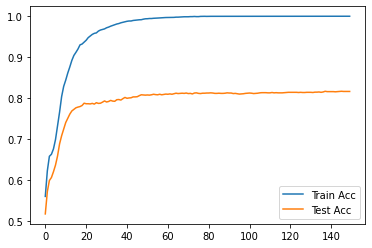

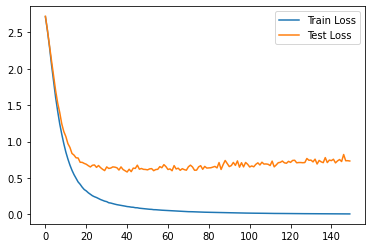

In [17]:
trained_model = train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=20, plot=True)

In [18]:
print("***Training Data Evaluation Example***")
test_loader = generate_dataset(X_train, y_train, batch_size=1)
probabilitites_train, test_loss, accuracy, _ = test(trained_model, test_loader, criterion, prob=True)
print(f"Accuracy: {accuracy:.4f}, loss: {test_loss:.4f}")

***Training Data Evaluation Example***
Accuracy: 1.0000, loss: 0.0076


In [19]:
print(probabilitites_train[0])

[1.7161462437798036e-06, 1.335618071607314e-05, 0.0005154526443220675, 0.9898536801338196, 6.72343321639346e-06, 3.883589306497015e-05, 1.4922577975085005e-05, 3.146079325233586e-05, 1.1779101441788953e-05, 0.00022637475922238082, 8.7923945102375e-05, 0.008990395814180374, 9.320050594396889e-05, 4.730280124931596e-05, 3.6149976949673146e-05, 2.2477563106804155e-05, 5.037914888816886e-06, 3.1926333576848265e-06]


In [20]:
idx = torch.argmax(torch.from_numpy(np.array(probabilitites_train[0])))
print(idx)
probabilitites_train[0][idx.item()]

tensor(3)


0.9898536801338196

In [21]:
print("***Testing Data Evaluation Example***")
test_loader = generate_dataset(X_test, y_test, batch_size=1, shuffle=False)
probabilitites_test, test_loss, accuracy, _ = test(trained_model, test_loader, criterion, prob=True)
print(f"Accuracy: {accuracy:.4f}, loss: {test_loss:.4f}")

***Testing Data Evaluation Example***
Accuracy: 0.8164, loss: 0.7553


In [22]:
print(probabilitites_test[:1])

[[1.3694295830646297e-07, 6.507685611722991e-06, 8.002200956980232e-06, 0.9998666048049927, 6.882731327095826e-07, 9.898338248603977e-06, 1.1649874977592845e-05, 4.5059409785608295e-06, 3.332913365738932e-06, 8.269104796454485e-07, 6.880939326947555e-05, 2.9051120691292454e-06, 6.2769449868937954e-06, 2.8173374175821664e-06, 3.1500367185799405e-06, 1.3424515827864525e-06, 2.2865506252855994e-06, 2.806132783916837e-07]]


In [23]:
idx = torch.argmax(torch.from_numpy(np.array(probabilitites_test[0])))
print(idx)
probabilitites_test[0][idx.item()]

tensor(3)


0.9998666048049927

In [24]:
def threshold_membership_inference(target_model,
                                   threshold=0.9):
    
    # attacker gets a set of samples
    data = pd.read_csv('../input/eestech-challenge-4-local-round-xanthi/dataset.csv', header=0)
    # print(data['target'].value_counts())

    columns = list(data.columns)
    columns = columns[:len(columns) - 1]
    X = data.loc[:, columns].to_numpy()
    y = data.target.to_numpy().ravel()

    num_classes = len(np.unique(y))
    dataset = X, y
    
    # attacker queries the model
    target_model.eval()
    
    softmax = torch.nn.Softmax(dim=0)
    target_correct = 0
    idx_membership = {}
    attack_correct = 0
    
    with torch.no_grad():
        for i in range(len(X)): # for each sample in the given dataset
            # transform to torch tensor
            tmp_x, tmp_y = torch.from_numpy(X[i]).float(), int(y[i])
            # query the model
            out = target_model(tmp_x)
            # get confidence scores
            probability = softmax(out) 
            pred = out.argmax().item() 
            if pred == tmp_y:
                target_correct += 1
            
            # get the maximum confidence score for a sample
            max_prob = torch.max(probability).item()
            # insert sample to members if max_prob > threshold
            if max_prob > threshold:
                membership_pred = 1
            else:
                membership_pred = 0
            idx_membership[i] = membership_pred
    print("Target Acc:", target_correct / len(X))
    return idx_membership        

In [25]:
predictions = threshold_membership_inference(trained_model,threshold=0.9)

Target Acc: 0.9448950688811639


In [26]:
def get_membership_score(membership, predictions):
    assert len(membership) == len(predictions)
    correct = 0
    y_true, y_pred = [], []
    for key in predictions:
        if predictions[key] == membership[key]:
            correct += 1
        y_true.append(membership[key])
        y_pred.append(predictions[key])
        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

    print(f"Correct predictions: {correct}/{len(predictions)}")
    print(f"Accuracy: {correct / len(predictions):.4f}")
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f"Attack Precision: {precision}")
    print(f"Attack Recall: {recall}")
    print(f"Advantage (= tpr - fpr): {tpr[1] - fpr[1]}")

In [27]:
get_membership_score(membership, predictions)

Correct predictions: 5958/7767
Accuracy: 0.7671
TP: 5411, TN: 547, FP: 1784, FN: 25
Attack Precision: 0.7520500347463517
Attack Recall: 0.9954010301692421
Advantage (= tpr - fpr): 0.23006426483247677


In [28]:
def correct_membership_inference(target_model):
    
    # attacker gets a set of samples
    data = pd.read_csv('../input/eestech-challenge-4-local-round-xanthi/dataset.csv', header=0)
    # print(data['target'].value_counts())

    columns = list(data.columns)
    columns = columns[:len(columns) - 1]
    X = data.loc[:, columns].to_numpy()
    y = data.target.to_numpy().ravel()

    num_classes = len(np.unique(y))
    dataset = X, y
    
    # attacker queries the model
    target_model.eval()
    
    
    target_correct = 0
    idx_membership = {}
    attack_correct = 0
    
    with torch.no_grad():
        for i in range(len(X)): # for each sample in the given dataset
            # transform to torch tensor
            tmp_x, tmp_y = torch.from_numpy(X[i]).float(), int(y[i])
            # query the model
            out = target_model(tmp_x)
            # get confidence scores
            
            pred = out.argmax().item() 
            if pred == tmp_y:
                target_correct += 1
                membership_pred = 1
            else:
                membership_pred = 0
            
            idx_membership[i] = membership_pred
    print("Target Acc:", target_correct / len(X))
    return idx_membership 

In [29]:
predictions = correct_membership_inference(trained_model)
get_membership_score(membership, predictions)

Target Acc: 0.9448950688811639
Correct predictions: 5864/7767
Accuracy: 0.7550
TP: 5436, TN: 428, FP: 1903, FN: 0
Attack Precision: 0.7407003678975337
Attack Recall: 1.0
Advantage (= tpr - fpr): 0.18361218361218357
